# Norwich House Price Forecasting Web Application using MLOps

This Jupyter notebook documents a web application that forecasts house prices in Norwich using an ensemble of machine learning and deep learning models. The ensemble combines Recurrent Neural Networks (RNN), Long Short-Term Memory networks (LSTM), Convolutional Neural Networks (CNN), and XGBoost to leverage complementary modelling strengths. Models are trained on historical data from January 2016 to October 2022, and out-of-sample forecasts run from November 2022 through December 2025. The trained ensemble is served via a Flask web interface that accepts feature inputs and returns predicted prices.

Live demo: https://norwich-house-prices-prediction.onrender.com/

---

## Objectives

- Build robust, production-ready models for house-price prediction using time-series and tabular approaches.
- Combine sequence models (RNN, LSTM, CNN) with a gradient-boosted tree (XGBoost) in an ensemble to improve accuracy and resilience.
- Produce out-of-sample forecasts for November 2022 — December 2025.
- Deploy the ensemble as a Flask application with a user-friendly front end for feature input and prediction retrieval.

---

## Data

- **Training timeframe:** January 2016 — October 2022.
- **Forecast horizon:** November 2022 — December 2025.
- **Typical features:** temporal variables; property attributes (size, rooms, age); location encodings; engineered features from price history and external indicators.
- **Preprocessing steps:** missing-value handling; scaling/normalisation of numeric features; encoding categorical variables; constructing sequence windows for neural models.

---

## Modeling Approach

### RNN and LSTM
- Capture temporal dependencies in price series and lagged indicators.
- Inputs prepared as sliding windows to model short- and medium-term dynamics.

### CNN (1D)
- Extract local temporal patterns from sliding windows using 1D convolutions.
- Detect short-lived patterns and time-local feature interactions.

### XGBoost
- Model non-linear relationships in tabular features.
- Provide a robust baseline and strong performance on engineered features.

### Ensemble Strategy
- Combine model outputs via weighted averaging or a stacking meta-learner.
- Select weights or stacking model using time-aware cross-validation to avoid look-ahead bias.

---

## Evaluation

- Use time-series aware holdout and cross-validation schemes.
- **Primary metrics:** Root Mean Squared Error (RMSE), Goodness-of-fit (R-squared).
- Backtest across multiple historical windows to assess stability and generalisation for the November 2022 — December 2025 horizon.

---

## Deployment

- Export trained models and integrate them into a Flask application.
- Flask provides an API endpoint that accepts feature inputs (JSON or form data) and returns ensemble predictions.
- The web interface allows users to enter required features and view predicted prices.
- **Production considerations:** model artifact serialisation, input validation, logging, performance monitoring, scaling, and containerisation.

---

## Usage

1. Start the Flask application or visit the hosted demo at https://norwich-house-prices-prediction.onrender.com/.
2. Open the web interface in a browser.
3. Provide property features and any required temporal context.
4. Submit to receive a point forecast.

---


## Feature Descriptions

The CSV file 'house_prices' contains data on 2,895 residential properties traded in Norwich between January 2016
and October 2022. The variables are: 

*house:* Property number \
*price:* Sale price in thousands of pounds\
*beds:* Number of bedrooms \
*baths:* Number of bathrooms \
*recs:* Number of recreation rooms \
*garages:* Number of garages \
*type:* 1 if empty plot of land \
2 if flat  \
3 if bungalow  \
4 if chalet  \
5 if terraced house  \
6 if end-terraced house  \
7 if semi-detached house  \
8 if detached house  \
*pcode:* 1 if post code is NR1 (South and East Central Norwich)  \
2 if NR2 (West Central Norwich)  \
3 if NR3 (North Central Norwich) \
4 if NR4 (South-West Norwich) \
5 if NR5 (West Norwich) \
6 if NR6 (North Norwich) \
7 if NR7 (East Norwich) \
8 if NR8 (North-West Norwich) \
*sqm:* Internal area in square metres. \
*dg:* One if property has double glazing; zero otherwise \
*solar:* One if property has solar panels; zero otherwise \
*loft:* One if property has loft insulation; zero otherwise \
*gsize:* Size of Garden in square metres \
*poll:* Air pollution at property (measured in millionths of a gram of particulate matter per cubic metre of air) \
*noise:* Level of traffic noise at property (measured in Decibels, DB).
*age:* Age of property in years \
*month:* Month of transaction: 1 if Jan 2016; \
2 if Feb 2016; \
:
82 if Oct 2022. 

In [1]:
# ============================================
# Norwich House Price Prediction - Full Notebook
# ============================================

import os
import joblib
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Conv1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [2]:
# -----------------------------
# Paths
# -----------------------------
proj_root = r"C:\Users\muade\Desktop\MLOps"
csv_path = os.path.join(proj_root, "notebook", "house_prices.csv")
model_dir = os.path.join(proj_root, "app", "model")
os.makedirs(model_dir, exist_ok=True)

# -----------------------------
# Load and preprocess data
# -----------------------------
data = pd.read_csv(csv_path)

if "price" not in data.columns:
    raise RuntimeError("Target column 'price' not found in CSV")
if "house" not in data.columns:
    raise RuntimeError("Expected 'house' column for sequential split (1..2895)")

data['date'] = pd.to_datetime(data['date'], format='%b-%y')

data.set_index('date', inplace=True)

data.index.name = None

data.head()

,house,price,beds,baths,recs,garages,sqm,gsize,poll,noise,age,month,type,pcode,dg,solar,loft
2016-01-01,1,109.019,1,1,1,0,41.2,1.00,32,67,96,1,Flat,NR3,No Double glazing,No solar panels,No loft insulation
2016-01-01,2,314.734,2,1,2,1,82.8,111.20,13,36,43,1,Bungalow,NR5,Double glazing,No solar panels,Loft insulation
2016-01-01,3,209.448,2,1,1,0,65.2,110.25,15,25,93,1,Terraced house,NR1,No Double glazing,No solar panels,Loft insulation
2016-01-01,4,379.322,4,1,3,1,115.8,282.30,32,128,39,1,Semi-detached house,NR7,No Double glazing,No solar panels,Loft insulation
2016-01-01,5,260.069,2,1,1,0,81.3,130.90,36,83,0,1,End-terraced house,NR6,Double glazing,Solar panels,Loft insulation


### Exploratory Data Analysis

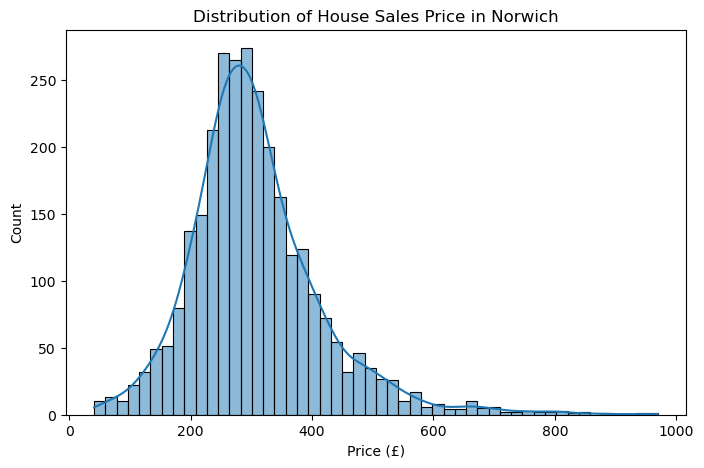

In [3]:
plt.figure(figsize=(8,5))
sns.histplot(data['price'], bins=50, kde=True)
plt.title("Distribution of House Sales Price in Norwich")
plt.xlabel("Price (£)")
plt.show()

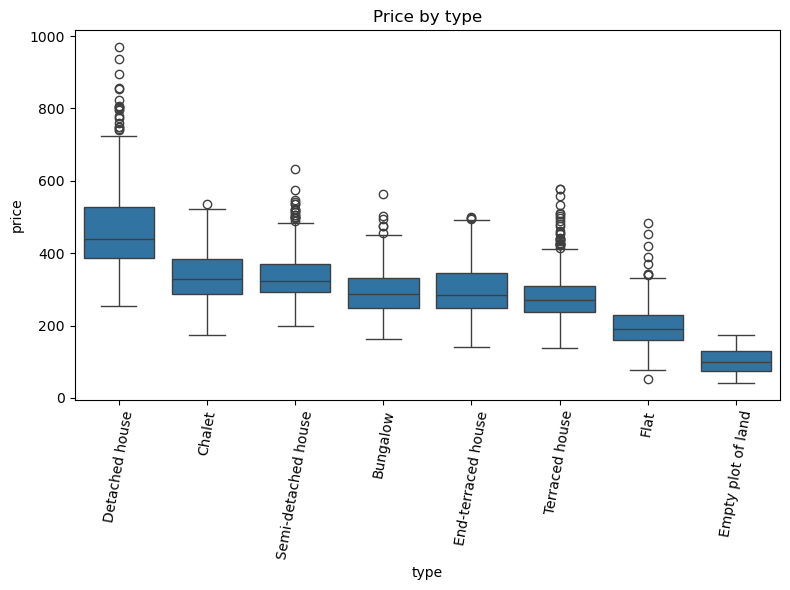

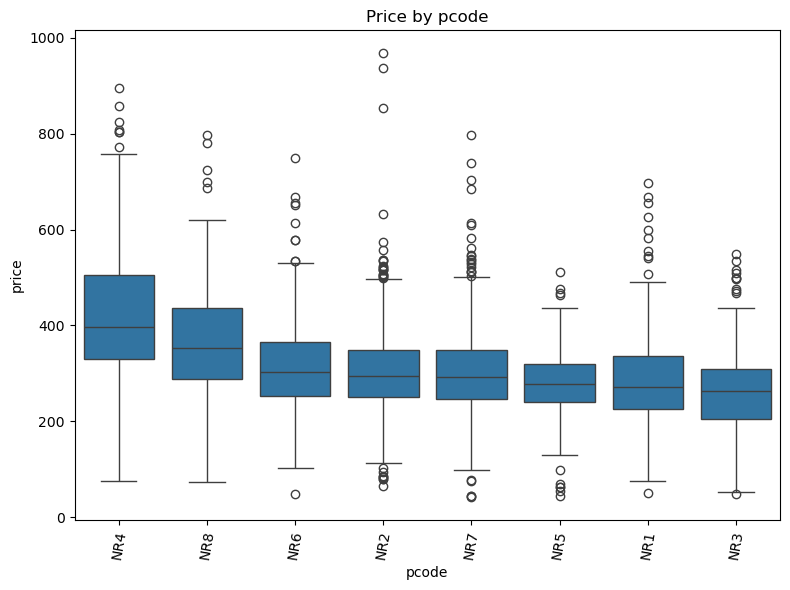

In [4]:
house_ids = data["house"]
cat_cols = ['type', 'pcode']

subset = data[(house_ids >= 1) & (house_ids <= 2895)].copy()

for col in cat_cols:
    if col not in subset.columns:
        continue

    if not pd.api.types.is_categorical_dtype(subset[col]):
        subset[col] = subset[col].astype('category')

    order = subset.groupby(col)['price'].median().sort_values(ascending=False).index

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='price', data=subset, order=order)
    plt.xticks(rotation=80)
    plt.title(f"Price by {col}")
    plt.tight_layout()
    plt.show()


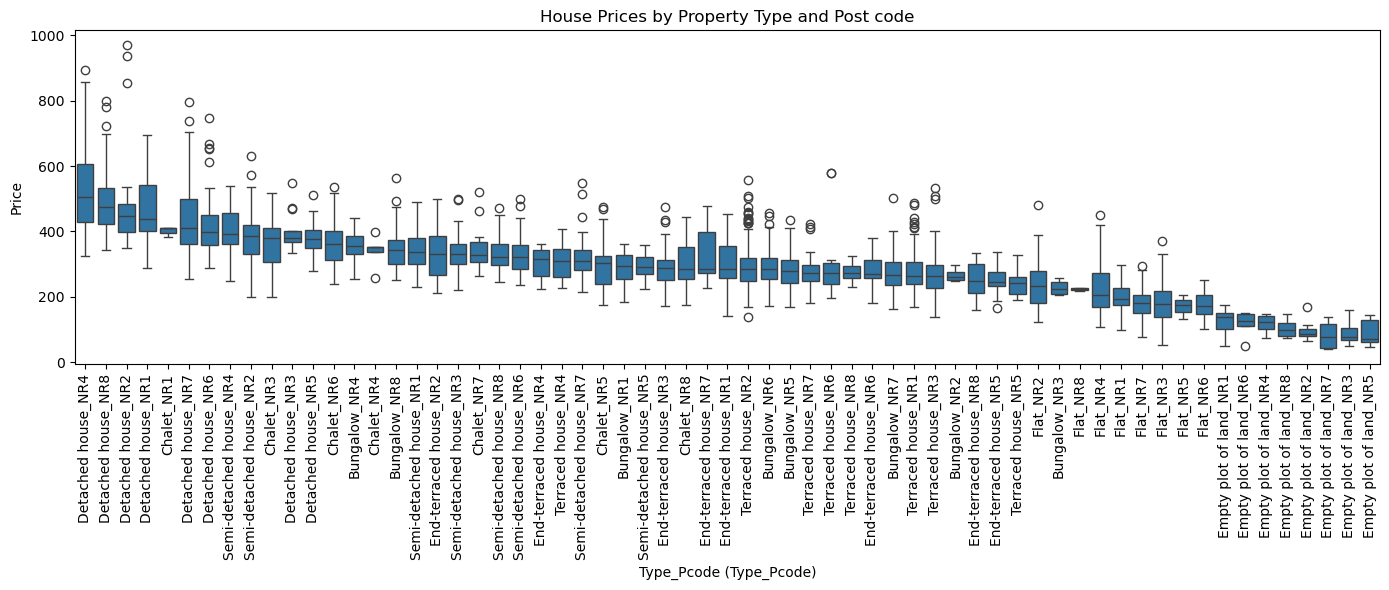

In [5]:
# Create a combined categorical column
subset["type_pcode"] = subset["type"].astype(str) + "_" + subset["pcode"].astype(str)

plt.figure(figsize=(14, 6))

order = (
    subset.groupby("type_pcode")["price"]
    .median()
    .sort_values(ascending=False)
    .index
)

sns.boxplot(x="type_pcode", y="price", data=subset, order=order)

plt.xticks(rotation=90)
plt.title("House Prices by Property Type and Post code")
plt.xlabel("Type_Pcode (Type_Pcode)")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

subset.drop('type_pcode', axis=1, inplace=True)


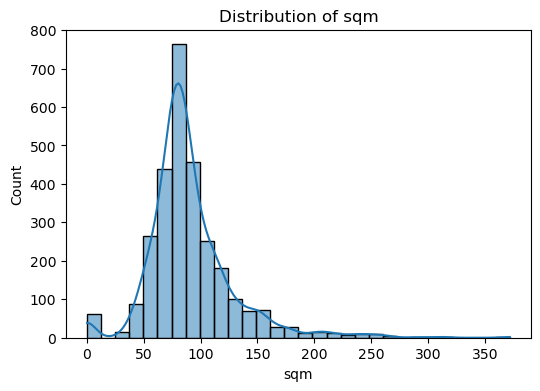

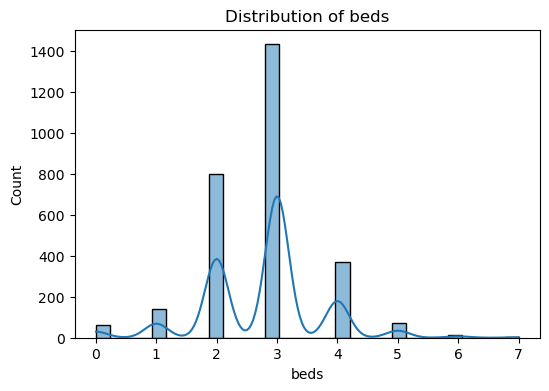

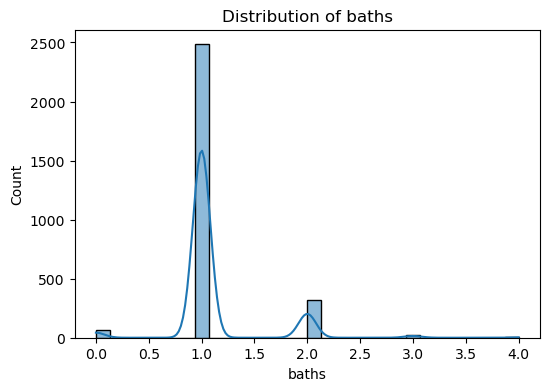

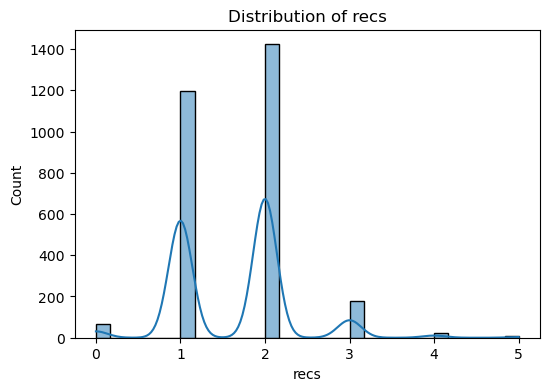

In [6]:
cols = ['sqm', 'beds', 'baths', 'recs']

for col in cols:
    plt.figure(figsize = (6,4))
    sns.histplot(subset[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

### Data preprocessing

In [7]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

feature_list = [
    "beds","baths","recs","garages","sqm","gsize","poll","noise","age","month",
    "type","pcode","dg","solar","loft"
]
df = data[[c for c in feature_list if c in data.columns]].copy()

num_cols = ['beds','baths','recs','garages','sqm','gsize','poll','noise','age','month']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0.0)


# one-hot encode categoricals
onehot_cols = [c for c in ['type','pcode','solar','dg','loft'] if c in df.columns]
if onehot_cols:
    df = pd.get_dummies(df, columns=onehot_cols, drop_first=False)


# target and features
y = pd.to_numeric(data['price'], errors='coerce').astype(np.float32)
X = df.apply(pd.to_numeric, errors='coerce').fillna(0.0).astype(np.float32)

# scale numeric features
scaler = StandardScaler()
num_to_scale = [c for c in num_cols if c in X.columns]
if num_to_scale:
    X[num_to_scale] = scaler.fit_transform(X[num_to_scale])

In [8]:
# -----------------------------
# Split: Train/Evaluation vs Prediction-only
# -----------------------------

train_eval_mask = (house_ids <= 2895) & (~y.isna())
X_train_eval = X.loc[train_eval_mask].values.astype(np.float32)
y_train_eval = y.loc[train_eval_mask].values.astype(np.float32)


pred_mask = house_ids >= 2896
X_pred = X.loc[pred_mask].values.astype(np.float32)
houses_pred = data.loc[pred_mask, "house"].values

print("Train/Eval set shape:", X_train_eval.shape, y_train_eval.shape)
print("Prediction-only set shape:", X_pred.shape)


X_train, X_test, y_train, y_test = train_test_split(
    X_train_eval, y_train_eval, test_size=0.2, random_state=SEED
)

X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
n_features  = X_train.shape[1]

Train/Eval set shape: (2895, 32) (2895,)
Prediction-only set shape: (1293, 32)


### Model Training & Evaluation

In [9]:
# -----------------------------
# Training
# -----------------------------
def eval_preds(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

results = {}
es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0)

# SimpleRNN
rnn = Sequential([SimpleRNN(96, activation='relu', input_shape=(1, n_features)), Dense(1)])
rnn.compile(optimizer=Adam(1e-3), loss='mse')
rnn_history = rnn.fit(X_train_rnn, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[es], verbose=0)
rnn_p = rnn.predict(X_test_rnn, verbose=0)
results['SimpleRNN'] = {'model': rnn, 'rmse': np.sqrt(mean_squared_error(y_test, rnn_p)), 'r2': r2_score(y_test, rnn_p)}

# LSTM
lstm = Sequential([LSTM(96, activation='relu', input_shape=(1, n_features)), Dense(1)])
lstm.compile(optimizer=Adam(1e-3), loss='mse')
lstm_history = lstm.fit(X_train_rnn, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[es], verbose=0)
lstm_p = lstm.predict(X_test_rnn, verbose=0)
results['LSTM'] = {'model': lstm, 'rmse': np.sqrt(mean_squared_error(y_test, lstm_p)), 'r2': r2_score(y_test, lstm_p)}

# CNN
cnn = Sequential([
    Conv1D(96, kernel_size=1, activation='relu', input_shape=(1, n_features)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
cnn.compile(optimizer=Adam(1e-3), loss='mse')
cnn_history = cnn.fit(X_train_rnn, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[es], verbose=0)
cnn_p = cnn.predict(X_test_rnn, verbose=0)
results['CNN'] = {'model': cnn, 'rmse': np.sqrt(mean_squared_error(y_test, cnn_p)), 'r2': r2_score(y_test, cnn_p)}

# XGBoost
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.05,
                       random_state=SEED, n_jobs=4, verbosity=0)
    xgb_history = xgb.fit(X_train, y_train)
    xgb_p = xgb.predict(X_test)
    results['XGBoost'] = {'model': xgb, 'rmse': np.sqrt(mean_squared_error(y_test, xgb_p)), 'r2': r2_score(y_test, xgb_p)}
except Exception as e:
    print("XGBoost skipped:", e)

print("Individual model performance:")
for name, info in results.items():
    print(f"  {name:10s} RMSE={info['rmse']:.4f}  R2={info['r2']:.4f}")

# -----------------------------
# Ensembles
# -----------------------------
preds_dict = {}
for name, info in results.items():
    model = info['model']
    is_keras = isinstance(model, tf.keras.Model)
    if is_keras:
        preds = model.predict(X_test_rnn, verbose=0).ravel()
    else:
        preds = model.predict(X_test).ravel()
    preds_dict[name] = preds

all_preds = np.vstack(list(preds_dict.values()))
ens_simple = np.mean(all_preds, axis=0)

# Weighted ensemble by 1/RMSE (on evaluation set y_test)
inv = np.array([1.0 / max(1e-8, np.sqrt(mean_squared_error(y_test, p))) for p in preds_dict.values()])
weights = inv / inv.sum()
ens_weighted = np.average(all_preds, axis=0, weights=weights)

def rmse_arr(a, b): return np.sqrt(mean_squared_error(np.asarray(a).ravel(), np.asarray(b).ravel()))
def r2_arr(a, b): return r2_score(np.asarray(a).ravel(), np.asarray(b).ravel())

ens_results = {
    'Ensemble_Simple': (rmse_arr(y_test, ens_simple), r2_arr(y_test, ens_simple)),
    'Ensemble_Weighted': (rmse_arr(y_test, ens_weighted), r2_arr(y_test, ens_weighted)),
}

print("\nEnsemble performance:")
for name, (rmse, r2) in ens_results.items():
    print(f"  {name:18s} RMSE={rmse:.4f}  R2={r2:.4f}")


Individual model performance:
  SimpleRNN  RMSE=24.2088  R2=0.9512
  LSTM       RMSE=23.6765  R2=0.9533
  CNN        RMSE=24.0186  R2=0.9519
  XGBoost    RMSE=25.4294  R2=0.9461

Ensemble performance:
  Ensemble_Simple    RMSE=23.5621  R2=0.9537
  Ensemble_Weighted  RMSE=23.5607  R2=0.9537


### Model peformance & selection

In [10]:
# -----------------------------
# Select best performer
# -----------------------------
best_name = None
best_rmse = float('inf')
best_r2 = -float('inf')

# individuals
for name, pred in preds_dict.items():
    cur_rmse, cur_r2 = rmse_arr(y_test, pred), r2_arr(y_test, pred)
    if cur_rmse < best_rmse or (np.isclose(cur_rmse, best_rmse) and cur_r2 > best_r2):
        best_name, best_rmse, best_r2 = name, cur_rmse, cur_r2

# ensembles
for name, (cur_rmse, cur_r2) in ens_results.items():
    if cur_rmse < best_rmse or (np.isclose(cur_rmse, best_rmse) and cur_r2 > best_r2):
        best_name, best_rmse, best_r2 = name, cur_rmse, cur_r2

print(f"\nBest on eval split: {best_name}  RMSE={best_rmse:.4f}  R2={best_r2:.4f}")

# -----------------------------
# Save models and ensemble spec
# -----------------------------
def save_individual(name, model, model_dir):
    is_keras = isinstance(model, tf.keras.Model)
    if is_keras:
        out = os.path.join(model_dir, f"{name}.h5")
        try:
            model.save(out) 
            return {'type': 'keras', 'file': os.path.basename(out)}
        except Exception:
            sm = os.path.join(model_dir, f"{name}_saved")
            model.save(sm)  
            return {'type': 'keras', 'file': os.path.basename(sm)}
    else:
        out = os.path.join(model_dir, f"{name}.pkl")
        joblib.dump(model, out)
        return {'type': 'sklearn', 'file': os.path.basename(out)}

final_model_meta_path = os.path.join(model_dir, "model.pkl")

if best_name in results.keys():
    # single model is best
    bm = results[best_name]['model']
    is_keras = isinstance(bm, tf.keras.Model)
    if is_keras:
        try:
            bm.save(os.path.join(model_dir, "best_model.h5"))
            joblib.dump({'type': 'keras', 'file': 'best_model.h5'}, final_model_meta_path)
            print("Saved Keras best model -> best_model.h5 (meta saved in model.pkl)")
        except Exception:
            sm = os.path.join(model_dir, "best_model_saved")
            bm.save(sm)
            joblib.dump({'type': 'keras', 'file': os.path.basename(sm)}, final_model_meta_path)
            print("Saved Keras best model -> SavedModel dir (meta saved in model.pkl)")
    else:
        joblib.dump({'type': 'sklearn', 'file': 'best_model.pkl'}, final_model_meta_path)
        joblib.dump(bm, os.path.join(model_dir, "best_model.pkl"))
        print("Saved sklearn/XGBoost best model -> best_model.pkl (meta saved in model.pkl)")
else:
    # ensemble chosen as best
    names = list(preds_dict.keys())
    inv = np.array([1.0 / max(1e-8, rmse_arr(y_test, preds_dict[n])) for n in names])
    wts = (inv / inv.sum()).tolist()
    comps = []
    for n in names:
        meta = save_individual(n, results[n]['model'], model_dir)
        comps.append(meta)

    ensemble_spec = {
        "components": comps,
        "weights": wts,
    }
    joblib.dump(ensemble_spec, final_model_meta_path)
    print("Saved ensemble spec -> model.pkl; component files:", [c['file'] for c in comps])

# -----------------------------
# Save preprocessing artifacts
# -----------------------------
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
joblib.dump(list(X.columns), os.path.join(model_dir, "feature_columns.pkl"))
print("Saved scaler.pkl and feature_columns.pkl")



Best on eval split: Ensemble_Weighted  RMSE=23.5607  R2=0.9537
Saved ensemble spec -> model.pkl; component files: ['SimpleRNN.h5', 'LSTM.h5', 'CNN.h5', 'XGBoost.pkl']
Saved scaler.pkl and feature_columns.pkl


### Out-of-sample Model prediction

In [11]:
# -----------------------------
# Prediction-only: houses 2800–2895 (November 2022 - December 2025)
# -----------------------------
print("\nGenerating predictions for houses 2800–2895 (no ground truth), forecast prices in thousand £ ...")

meta = joblib.load(final_model_meta_path)

# Prepare shape for keras models
X_pred_rnn = X_pred.reshape((X_pred.shape[0], 1, X_pred.shape[1]))

def load_component(comp):
    if comp["type"] == "keras":
        return tf.keras.models.load_model(os.path.join(model_dir, comp["file"])), True
    else:
        return joblib.load(os.path.join(model_dir, comp["file"])), False

if isinstance(meta, dict) and "components" in meta and "weights" in meta:
    # Ensemble prediction
    preds_sum = np.zeros(X_pred.shape[0], dtype=np.float32)
    for comp, w in zip(meta["components"], meta["weights"]):
        mdl, is_keras = load_component(comp)
        if is_keras:
            preds = mdl.predict(X_pred_rnn, verbose=0).ravel()
        else:
            preds = mdl.predict(X_pred).ravel()
        preds_sum += w * preds
    final_preds = preds_sum
else:
    # Single model
    if meta["type"] == "keras":
        mdl = tf.keras.models.load_model(os.path.join(model_dir, meta["file"]))
        final_preds = mdl.predict(X_pred_rnn, verbose=0).ravel()
    else:
        mdl = joblib.load(os.path.join(model_dir, meta["file"]))
        final_preds = mdl.predict(X_pred).ravel()

pred_df = pd.DataFrame({
    "house": houses_pred,
    "predicted_price": final_preds
})
print(pred_df.head())

out_csv = os.path.join(model_dir, "test_predictions.csv")
pred_df.to_csv(out_csv, index=False)
print(f"Saved predictions for houses 2800–2895 -> {out_csv}")


Generating predictions for houses 2800–2895 (no ground truth), forecast prices in thousand £ ...
   house  predicted_price
0   2896       329.251221
1   2897       415.997253
2   2898       452.487335
3   2899       289.997772
4   2900       502.145508
Saved predictions for houses 2800–2895 -> C:\Users\muade\Desktop\MLOps\app\model\test_predictions.csv


### Plotting Training & Validation loss, & Actual & In-sample Predicted Prices

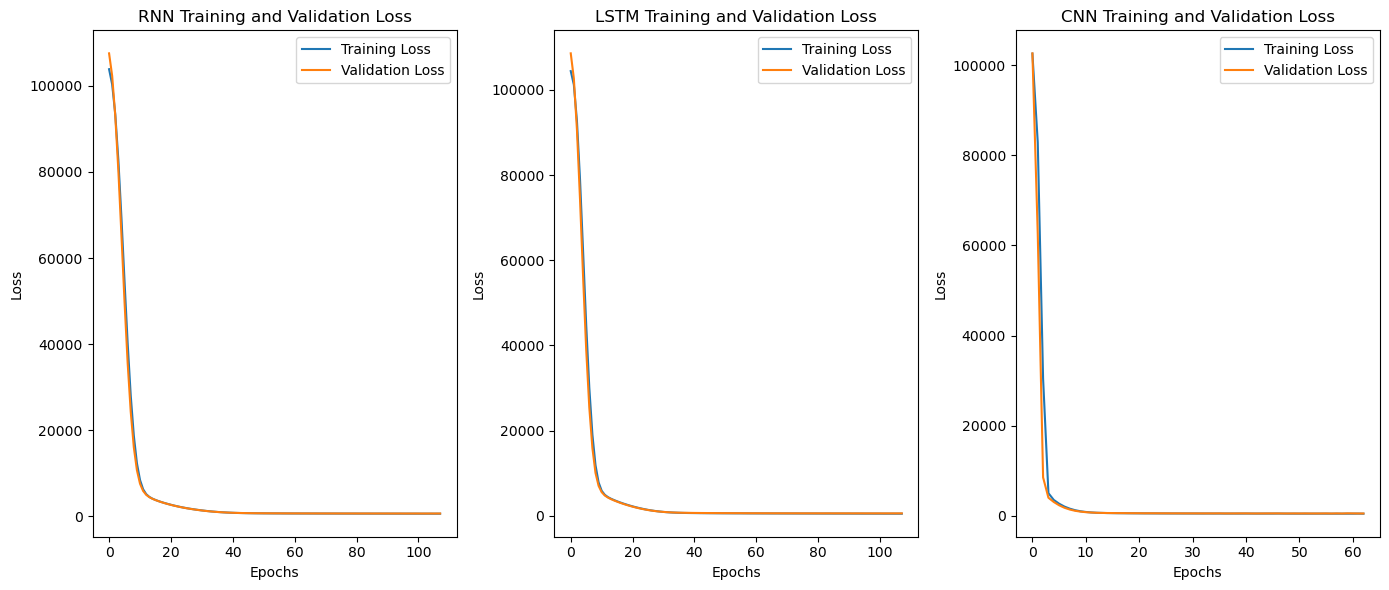

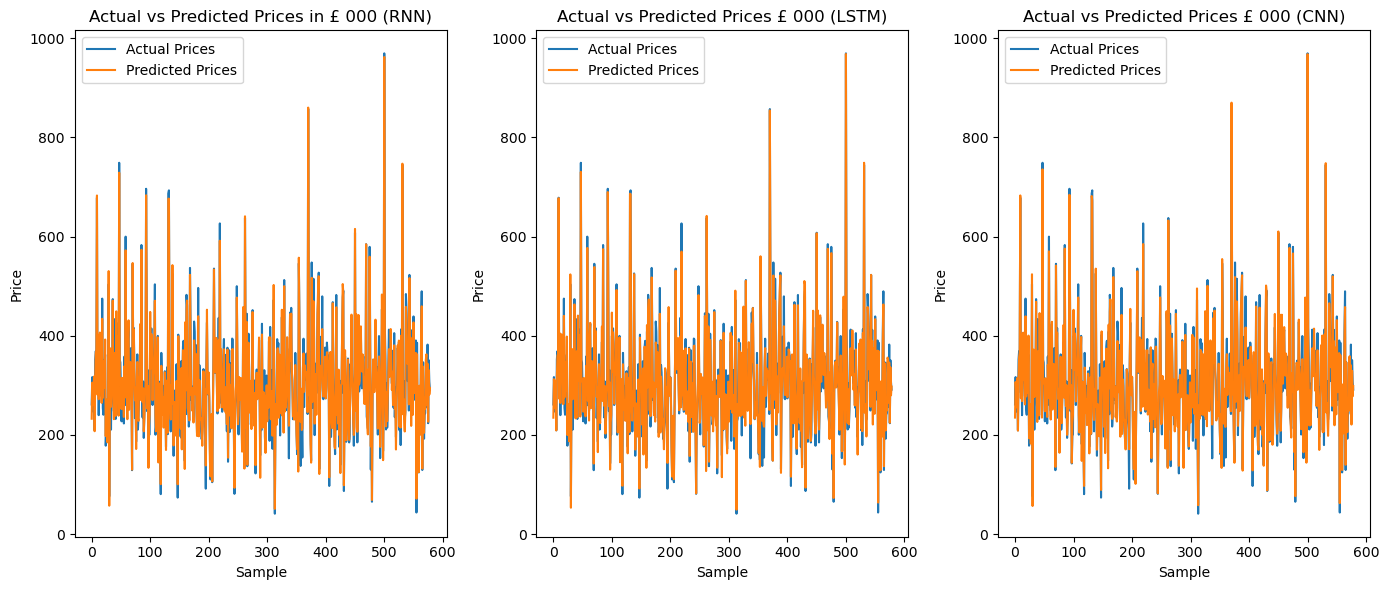

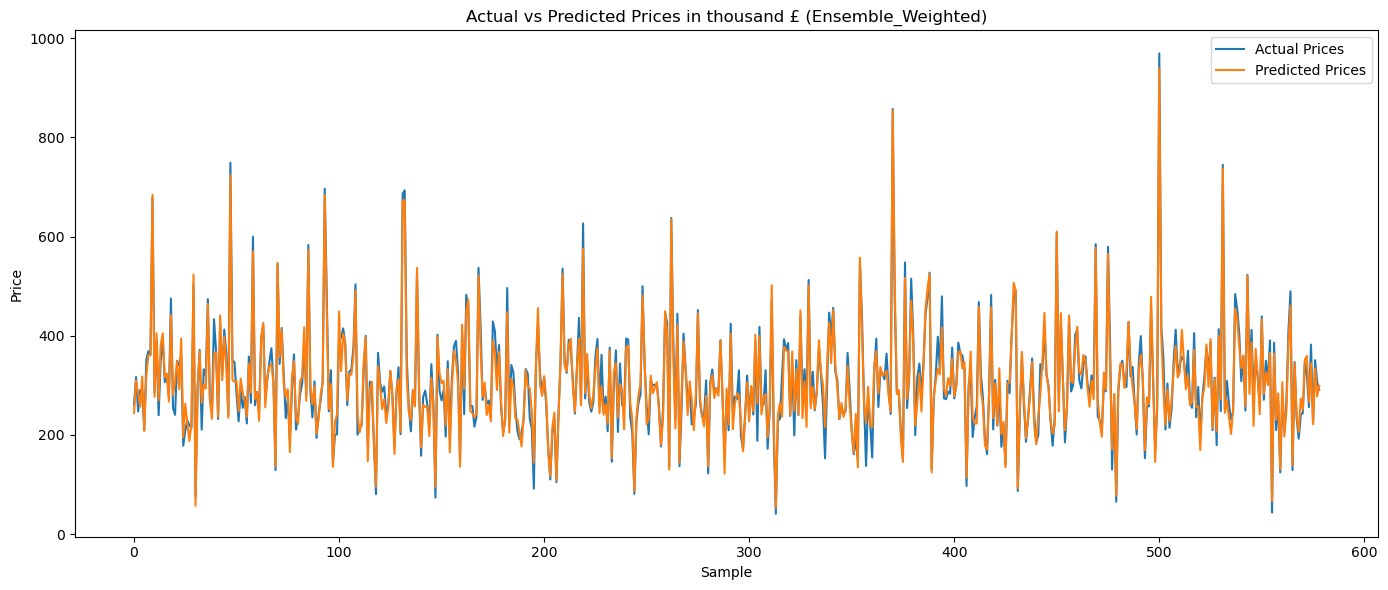

In [12]:
# Plot the loss for RNN, LSTM, and CNN
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the actual vs predicted prices for the test data for RNN, LSTM, and CNN

plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(y_test, label='Actual Prices')
plt.plot(rnn_p, label='Predicted Prices')
plt.title('Actual vs Predicted Prices in £ 000 (RNN)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(y_test, label='Actual Prices')
plt.plot(lstm_p, label='Predicted Prices')
plt.title('Actual vs Predicted Prices £ 000 (LSTM)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(y_test, label='Actual Prices')
plt.plot(cnn_p, label='Predicted Prices')
plt.title('Actual vs Predicted Prices £ 000 (CNN)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the actual vs predicted prices for the Ensemble_Weighted

plt.figure(figsize=(14, 6))

plt.plot(y_test, label='Actual Prices')
plt.plot(ens_weighted, label='Predicted Prices')
plt.title('Actual vs Predicted Prices in thousand £ (Ensemble_Weighted)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()